# [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108)

In this lecture, we will explore the architecture of DistilBERT, its key components, and how it can be utilized for various natural language processing tasks. Additionally, we'll discuss its advantages, limitations, and provide hands-on examples to showcase its effectiveness.

Reference : [The Theory](https://towardsdatascience.com/distillation-of-bert-like-models-the-code-73c31e8c2b0a) | [Code](https://towardsdatascience.com/distillation-of-bert-like-models-the-theory-32e19a02641f)

In [1]:
# TODO
# Find dataset - done
# train two students odd and even - process
# LORA train
# Make table evaluation and analysis - Evaluate the models on the test set, and analyze the performance of the models trained with Odd
 # Layers, Even Layers, and LoRA. Discuss the differences in performance across the three methods.
 # Discuss the challenges encountered during the implementation, specifically comparing distillation

In [2]:
import os
import copy
# Set GPU device
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# os.environ['http_proxy']  = 'http://192.41.170.23:3128'
# os.environ['https_proxy'] = 'http://192.41.170.23:3128'

!pip install datasets transformers evaluate
import datasets

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import Module
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm.auto import tqdm
import random, math, time
import numpy as np

!pip install opencv-python opencv-python-headless
import transformers
from transformers import TrainingArguments, Trainer, default_data_collator
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig
from transformers.models.bert.modeling_bert import BertEncoder, BertModel
from transformers import get_scheduler

print(datasets.__version__, transformers.__version__, torch.__version__)

import evaluate

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

!pip install peft
from peft import LoraConfig, TaskType, get_peft_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.7 MB/s eta 0:00:00
3.3.1 4.47.0 2.5.1+cu121


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [4]:
# from huggingface_hub import login
# login()

## 1. Loading our MNLI part of the GLUE dataset

In [5]:
###1. Load Dataset
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("comment_text", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
    "cstm": ("comment_text", None),
}

task_name = "cstm"
# dataset: https://huggingface.co/datasets/OxAISH-AL-LLM/wiki_toxic
# https://huggingface.co/datasets/mteb/toxic_conversations_50k
# raw_datasets = datasets.load_dataset("glue", task_name)
raw_datasets = datasets.load_dataset("OxAISH-AL-LLM/wiki_toxic")
raw_datasets

README.md:   0%|          | 0.00/4.30k [00:00<?, ?B/s]

wiki_toxic.py:   0%|          | 0.00/4.55k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/35.2M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/8.85M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/6.18M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/127656 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/31915 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/63978 [00:00<?, ? examples/s]

Generating balanced_train split:   0%|          | 0/25868 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 127656
    })
    validation: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 31915
    })
    test: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 63978
    })
    balanced_train: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 25868
    })
})

In [6]:
label_list = raw_datasets['balanced_train'].features['label'].names
label2id = {v: i for i, v in enumerate(label_list)}
label2id

{'non': 0, 'tox': 1}

In [7]:
id2label = {i: v for v, i in label2id.items()}
id2label

{0: 'non', 1: 'tox'}

## 2. Model & Tokenization

In [8]:
num_labels = np.unique(raw_datasets['balanced_train']['label']).size
num_labels

2

<img src = "figures/BERT_embed.png" width=500>

In [9]:
teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id,
    num_labels = num_labels,
    id2label = id2label,
    label2id = label2id,
)

teacher_model

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## 3. Preprocessing

In [10]:
def tokenize_function(examples):
    sentence1_key, sentence2_key = task_to_keys[task_name]
    args = (
        (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
    )
    result = tokenizer(*args, max_length=128, truncation=True)
    return result

In [11]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/127656 [00:00<?, ? examples/s]

Map:   0%|          | 0/31915 [00:00<?, ? examples/s]

Map:   0%|          | 0/63978 [00:00<?, ? examples/s]

Map:   0%|          | 0/25868 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'comment_text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 127656
    })
    validation: Dataset({
        features: ['id', 'comment_text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 31915
    })
    test: Dataset({
        features: ['id', 'comment_text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 63978
    })
    balanced_train: Dataset({
        features: ['id', 'comment_text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25868
    })
})

In [12]:
# list(task_to_keys[task_name])
column_dataset = [item for item in task_to_keys[task_name] if item is not None]
column_dataset

['comment_text']

In [13]:
#remove column : 'premise', 'hypothesis', 'idx'
tokenized_datasets = tokenized_datasets.remove_columns(column_dataset + ["id"])
#rename column : 'labels'
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 127656
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 31915
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 63978
    })
    balanced_train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25868
    })
})

In [14]:
tokenized_datasets['balanced_train'][0]['input_ids']

tensor([  101,  1000,  2025,  2065,  1045,  2064,  2393,  2009,  1012,  8494,
        14540,  5178,  2003,  2062,  2066,  2009,  1012,  1012,  1012,  1012,
        13029,  1000,   102])

In [15]:
tokenizer.decode(tokenized_datasets['balanced_train'][0]['input_ids'])

'[CLS] " not if i can help it. mudslide is more like it.... 127 " [SEP]'

## 4. Preparing the dataloader

In [16]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#Data collator that will dynamically pad the inputs received.

In [17]:
small_train_dataset = tokenized_datasets["balanced_train"].shuffle(seed=1150).select(range(25868))
small_eval_dataset = tokenized_datasets["validation"].shuffle(seed=1150).select(range(1000))
small_test_dataset = tokenized_datasets["test"].shuffle(seed=1150).select(range(1000))

In [18]:
train_dataloader = DataLoader(
    small_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator)
test_dataloader = DataLoader(
    small_test_dataset, batch_size=32, collate_fn=data_collator)
eval_dataloader = DataLoader(
    small_eval_dataset, batch_size=32, collate_fn=data_collator)

In [19]:
for batch in train_dataloader:
    break

batch['labels'].shape, batch['input_ids'].shape, batch['attention_mask'].shape

(torch.Size([32]), torch.Size([32, 128]), torch.Size([32, 128]))

## 5. Design the model and losses

### 5.1 Teacher Model & Student Model

####  Architecture
In the present work, the student - DistilBERT - has the same general architecture as BERT.
- The `token-type embeddings` and the `pooler` are removed while `the number of layers` is reduced by a factor of 2.
- Most of the operations used in the Transformer architecture `linear layer` and `layer normalisation` are highly optimized in modern linear algebra frameworks.
- our investigations showed that variations on the last dimension of the tensor (hidden size dimension) have a smaller impact on computation efficiency (for a fixed parameters budget) than variations on other factors like the number of layers.
- Thus we focus on reducing the number of layers.

#### Initialize Student Model
- To initialize a new model from an existing one, we need to access the weights of the old model (the teacher).
- In order to get the weights, we first have to know how to access them. We’ll use BERT as our teacher model.

In [20]:
teacher_model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "non",
    "1": "tox"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "non": 0,
    "tox": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.47.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

####
- The student model has the same configuration, except the number of layers is reduced by a factor of 2
- The student layers are initilized by copying one out of two layers of the teacher, starting with layer 0.
- The head of the teacher is also copied.

In [21]:
# Get teacher configuration as a dictionnary
configuration = teacher_model.config.to_dict()
# configuration

In [22]:
# Half the number of hidden layer
configuration['num_hidden_layers'] //= 2
# Convert the dictionnary to the student configuration
conf_odd  = BertConfig.from_dict(configuration)
conf_even = copy.deepcopy(BertConfig.from_dict(configuration))

In [23]:
# Create uninitialized student model
model_odd = type(teacher_model)(conf_odd)
model_odd

# Create uninitialized student model
model_even = type(teacher_model)(conf_even)
model_even

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

- Recursively copies the weights of the (teacher) to the (student).
- This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
- The only part that's not fully copied is the encoder, of which only half is copied.

In [24]:
def distill_bert_weights(
    teacher : Module,
    student : Module,
    iseven: bool,
) -> None:
    """
    Recursively copies the weights of the (teacher) to the (student).
    This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
    The only part that's not fully copied is the encoder, of which only half is copied.
    """
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights(teacher_part, student_part, iseven)
    # Else if the part is an encoder, copy one out of every layer
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())] #12 layers
        student_encoding_layers = [layer for layer in next(student.children())] #6 layers
        # for i in range(len(student_encoding_layers)):
        #     student_encoding_layers[i].load_state_dict(teacher_encoding_layers[2*i].state_dict())
        j = 0
        for i in range(len(teacher_encoding_layers)):
            # ODD
            if not iseven and i % 2:
                student_encoding_layers[j].load_state_dict(teacher_encoding_layers[i].state_dict())
                j += 1
            elif iseven and i % 2 == 0:
                student_encoding_layers[j].load_state_dict(teacher_encoding_layers[i].state_dict())
                j += 1

    # Else the part is a head or something else, copy the state_dict
    else:
        student.load_state_dict(teacher.state_dict())

    return student

In [25]:
model_odd = distill_bert_weights(teacher=teacher_model, student=model_odd, iseven=False)
model_even = distill_bert_weights(teacher=teacher_model, student=model_even, iseven=True)

In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Teacher parameters :', count_parameters(teacher_model))
print('Student parameters even layers:', count_parameters(model_even))
print('Student parameters odd layers:', count_parameters(model_odd))

Teacher parameters : 109483778
Student parameters even layers: 66956546
Student parameters odd layers: 66956546


In [27]:
print(count_parameters(model_even)/count_parameters(teacher_model) * 100)
print(count_parameters(model_odd)/count_parameters(teacher_model) * 100)

61.156590705154514
61.156590705154514


In [28]:
#It has 61% less parameters than bert-base-uncased

### 5.2 Loss function

#### Softmax

$$
P_i(\mathbf{z}_i, T) = \frac{\exp(\mathbf{z}_i / T)}{\sum_{q=0}^k \exp(\mathbf{z}_q / T)}
$$


#### Knowledge Distillation

#### CE Loss
$$\mathcal{L}_\text{CE} = -\sum^N_{j=0}\sum_{i=0}^k {y}_i^{(j)}\log(P_i({v}_i^{(j)}, 1))$$

#### KL Loss
$$\mathcal{L}_\text{KD} = -\sum^N_{j=0}\sum_{i=0}^k P_i({z}_i^{(j)}, T) \log (P_i({v}_i^{(j)}, T))$$

#### Cosine Embedding Loss
$$\mathcal{L}_{\text{cosine}}(x_1, x_2, y) = \frac{1}{N} \sum_{i=1}^{N} \left(1 - y_i \cdot \cos(\theta_i)\right)$$

<!-- $$\mathcal{L} = \lambda \mathcal{L}_\text{KD} + (1-\lambda)\mathcal{L}_\text{CE}$$
 -->

#### Total Loss
$$\mathcal{L} = \mathcal{L}_\text{KD} + \mathcal{L}_\text{CE} + \mathcal{L}_{\text{cosine}}$$

In [29]:
class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha

    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities!
    """

    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        '''
        Note: the output_student and output_teacher are logits
        '''
        T = temperature #.cuda()

        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T

        return KD_loss

In [30]:
criterion_div = DistillKL()
criterion_cos = nn.CosineEmbeddingLoss()

## 6. Optimizer

In [31]:
lr = 5e-5

#training hyperparameters
optimizer_even = optim.Adam(params=model_even.parameters(), lr=lr)
optimizer_odd  = optim.Adam(params=model_odd.parameters(), lr=lr)

In [32]:
model_even = model_even.to(device)
model_odd  = model_odd.to(device)
teacher_model = teacher_model.to(device)

## 7. Learning rate scheduler

In [33]:
num_epochs = 5
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

lr_scheduler_even = get_scheduler(
    name="linear",
    optimizer=optimizer_even,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

lr_scheduler_odd = get_scheduler(
    name="linear",
    optimizer=optimizer_odd,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

## 8. Metric

In [34]:
# !pip3 install evaluate

In [35]:

# Get the metric function
# if task_name is not None:
#     metric = evaluate.load("glue", "sst2")
# else:
metric = evaluate.load("accuracy")

## 9. Train

In [36]:
progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0

# Lists to store losses for each epoch
train_losses_odd = []
train_losses_cls_odd = []
train_losses_div_odd = []
train_losses_cos_odd = []
eval_losses_odd = []

for epoch in range(num_epochs):
    model_odd.train()
    teacher_model.eval()
    train_loss = 0
    train_loss_cls = 0
    train_loss_div = 0
    train_loss_cos = 0

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        # compute student output
        outputs = model_odd(**batch)
        # compute teacher output
        with torch.no_grad():
            output_teacher = teacher_model(**batch)

        # assert size
        assert outputs.logits.size() == output_teacher.logits.size()

        # cls loss
        loss_cls  = outputs.loss
        train_loss_cls += loss_cls.item()
        # distillation loss
        loss_div = criterion_div(outputs.logits, output_teacher.logits)
        train_loss_div += loss_div.item()
        # cosine loss
        loss_cos = criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
        train_loss_cos += loss_cos.item()

        # Average the loss and return it
        loss = (loss_cls + loss_div + loss_cos) / 3

        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer_odd.step()
        lr_scheduler_odd.step()
        optimizer_odd.zero_grad()
        progress_bar.update(1)

    train_losses_odd.append(train_loss / len(train_dataloader))
    train_losses_cls_odd.append(train_loss_cls / len(train_dataloader))
    train_losses_div_odd.append(train_loss_div / len(train_dataloader))
    train_losses_cos_odd.append(train_loss_cos / len(train_dataloader))

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
    print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
    print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
    print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')

    model_odd.eval()
    eval_loss = 0
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model_odd(**batch)

        loss_cls = outputs.loss
        predictions = outputs.logits.argmax(dim=-1)

        eval_loss += loss_cls.item()
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions,
            references=batch["labels"])

    eval_metric = metric.compute()
    eval_metrics += eval_metric['accuracy']
    eval_losses_odd.append(eval_loss / len(eval_dataloader))  # Save the evaluation loss for plotting

    print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")

print('Avg Metric', eval_metrics/num_epochs)

  0%|          | 0/4045 [00:00<?, ?it/s]

Epoch at 1: Train loss 0.1955:
  - Loss_cls: 0.4242
  - Loss_div: 0.1021
  - Loss_cos: 0.0601
Epoch at 1: Test Acc 0.8940
Epoch at 2: Train loss 0.1799:
  - Loss_cls: 0.3635
  - Loss_div: 0.1239
  - Loss_cos: 0.0524
Epoch at 2: Test Acc 0.9390
Epoch at 3: Train loss 0.1735:
  - Loss_cls: 0.3368
  - Loss_div: 0.1332
  - Loss_cos: 0.0504
Epoch at 3: Test Acc 0.9390
Epoch at 4: Train loss 0.1699:
  - Loss_cls: 0.3228
  - Loss_div: 0.1378
  - Loss_cos: 0.0492
Epoch at 4: Test Acc 0.9210
Epoch at 5: Train loss 0.1682:
  - Loss_cls: 0.3166
  - Loss_div: 0.1399
  - Loss_cos: 0.0482
Epoch at 5: Test Acc 0.9280
Avg Metric 0.9241999999999999


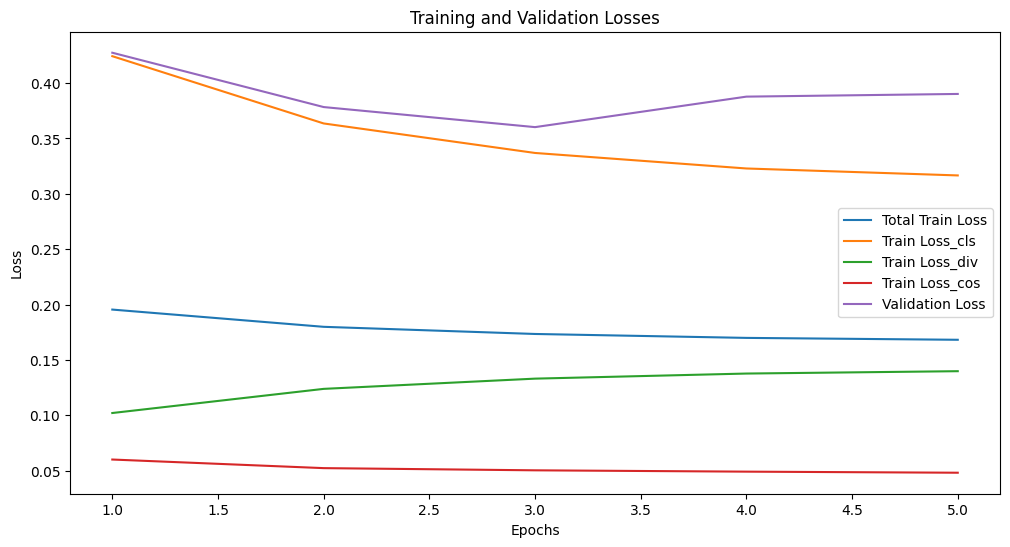

In [37]:
# Plotting
epochs_list = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs_list, train_losses_odd, label='Total Train Loss')
plt.plot(epochs_list, train_losses_cls_odd, label='Train Loss_cls')
plt.plot(epochs_list, train_losses_div_odd, label='Train Loss_div')
plt.plot(epochs_list, train_losses_cos_odd, label='Train Loss_cos')
plt.plot(epochs_list, eval_losses_odd, label='Validation Loss')

plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

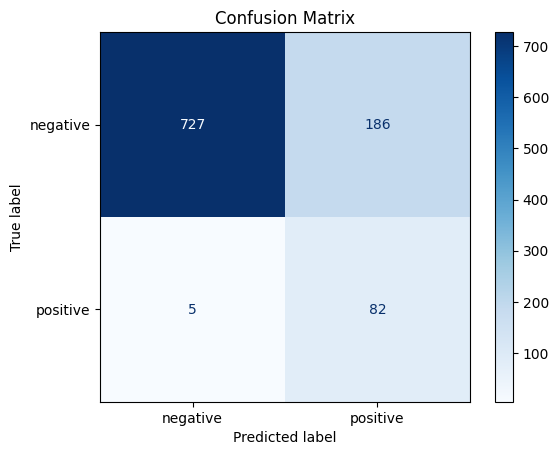

              precision    recall  f1-score   support

    negative       0.99      0.80      0.88       913
    positive       0.31      0.94      0.46        87

    accuracy                           0.81      1000
   macro avg       0.65      0.87      0.67      1000
weighted avg       0.93      0.81      0.85      1000



In [38]:
y_true_odd = []
y_pred_odd = []

for batch in test_dataloader:
    input_ids, attention_mask, labels = batch['input_ids'], batch['attention_mask'], batch['labels']
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model_odd(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1)

        y_true_odd.extend(labels.cpu().numpy())
        y_pred_odd.extend(batch_predictions.cpu().numpy())

accuracy_odd = accuracy_score(y_true_odd, y_pred_odd)
precision_odd = precision_score(y_true_odd, y_pred_odd, average='weighted')
recall_odd = recall_score(y_true_odd, y_pred_odd, average='weighted')
f1_odd = f1_score(y_true_odd, y_pred_odd, average='weighted')

labels = ["negative", "positive"]

ConfusionMatrixDisplay.from_predictions(
    y_true_odd,
    y_pred_odd,
    display_labels=labels,
    cmap=plt.cm.Blues,
    xticks_rotation='horizontal'
)

plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true_odd, y_pred_odd, target_names=labels))

In [39]:
progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0

# Lists to store losses for each epoch
train_losses_even = []
train_losses_cls_even = []
train_losses_div_even = []
train_losses_cos_even = []
eval_losses_even = []

for epoch in range(num_epochs):
    model_even.train()
    teacher_model.eval()
    train_loss = 0
    train_loss_cls = 0
    train_loss_div = 0
    train_loss_cos = 0

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        # compute student output
        outputs = model_even(**batch)
        # compute teacher output
        with torch.no_grad():
            output_teacher = teacher_model(**batch)

        # assert size
        assert outputs.logits.size() == output_teacher.logits.size()

        # cls loss
        loss_cls  = outputs.loss
        train_loss_cls += loss_cls.item()
        # distillation loss
        loss_div = criterion_div(outputs.logits, output_teacher.logits)
        train_loss_div += loss_div.item()
        # cosine loss
        loss_cos = criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
        train_loss_cos += loss_cos.item()

        # Average the loss and return it
        loss = (loss_cls + loss_div + loss_cos) / 3

        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer_even.step()
        lr_scheduler_even.step()
        optimizer_even.zero_grad()
        progress_bar.update(1)

    train_losses_even.append(train_loss / len(train_dataloader))
    train_losses_cls_even.append(train_loss_cls / len(train_dataloader))
    train_losses_div_even.append(train_loss_div / len(train_dataloader))
    train_losses_cos_even.append(train_loss_cos / len(train_dataloader))

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
    print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
    print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
    print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')

    model_even.eval()
    eval_loss = 0
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model_even(**batch)

        loss_cls = outputs.loss
        predictions = outputs.logits.argmax(dim=-1)

        eval_loss += loss_cls.item()
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions,
            references=batch["labels"])

    eval_metric = metric.compute()
    eval_metrics += eval_metric['accuracy']
    eval_losses_even.append(eval_loss / len(eval_dataloader))  # Save the evaluation loss for plotting

    print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")

print('Avg Metric', eval_metrics/num_epochs)

  0%|          | 0/4045 [00:00<?, ?it/s]

Epoch at 1: Train loss 0.1955:
  - Loss_cls: 0.4183
  - Loss_div: 0.1057
  - Loss_cos: 0.0626
Epoch at 1: Test Acc 0.9270
Epoch at 2: Train loss 0.1804:
  - Loss_cls: 0.3601
  - Loss_div: 0.1266
  - Loss_cos: 0.0545
Epoch at 2: Test Acc 0.9100
Epoch at 3: Train loss 0.1734:
  - Loss_cls: 0.3349
  - Loss_div: 0.1345
  - Loss_cos: 0.0509
Epoch at 3: Test Acc 0.9390
Epoch at 4: Train loss 0.1700:
  - Loss_cls: 0.3214
  - Loss_div: 0.1390
  - Loss_cos: 0.0497
Epoch at 4: Test Acc 0.9190
Epoch at 5: Train loss 0.1682:
  - Loss_cls: 0.3153
  - Loss_div: 0.1407
  - Loss_cos: 0.0487
Epoch at 5: Test Acc 0.9230
Avg Metric 0.9236000000000001


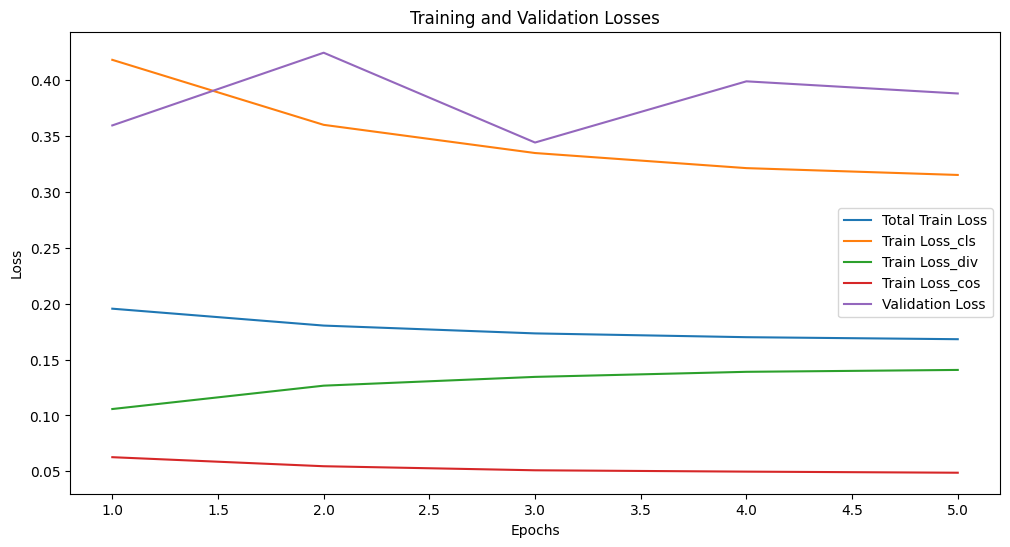

In [40]:
# Plotting
epochs_list = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs_list, train_losses_even, label='Total Train Loss')
plt.plot(epochs_list, train_losses_cls_even, label='Train Loss_cls')
plt.plot(epochs_list, train_losses_div_even, label='Train Loss_div')
plt.plot(epochs_list, train_losses_cos_even, label='Train Loss_cos')
plt.plot(epochs_list, eval_losses_even, label='Validation Loss')

plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

              precision    recall  f1-score   support

    negative       0.99      0.80      0.89       913
    positive       0.31      0.91      0.46        87

    accuracy                           0.81      1000
   macro avg       0.65      0.86      0.67      1000
weighted avg       0.93      0.81      0.85      1000



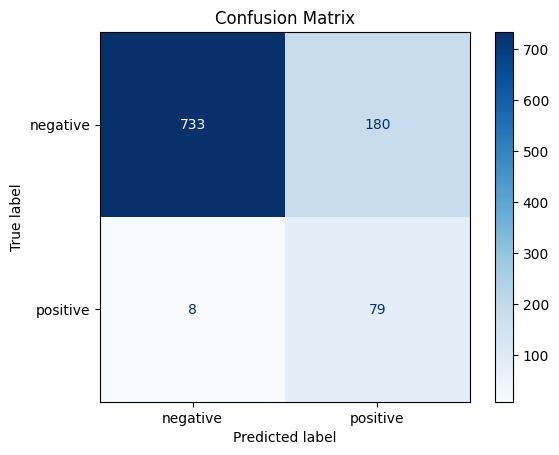

In [41]:
y_true_even = []
y_pred_even = []

for batch in test_dataloader:
    input_ids, attention_mask, labels = batch['input_ids'], batch['attention_mask'], batch['labels']
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model_even(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1)

        y_true_even.extend(labels.cpu().numpy())
        y_pred_even.extend(batch_predictions.cpu().numpy())

accuracy_even = accuracy_score(y_true_even, y_pred_even)
precision_even = precision_score(y_true_even, y_pred_even, average='weighted')
recall_even = recall_score(y_true_even, y_pred_even, average='weighted')
f1_even = f1_score(y_true_even, y_pred_even, average='weighted')

labels = ["negative", "positive"]

ConfusionMatrixDisplay.from_predictions(
    y_true_even,
    y_pred_even,
    display_labels=labels,
    cmap=plt.cm.Blues,
    xticks_rotation='horizontal'
)

plt.title('Confusion Matrix')
plt.show

print(classification_report(y_true_even, y_pred_even, target_names=labels))

### Appendix (Teacher Model)

In [42]:
lr = 5e-5
#training hyperparameters
optimizer = optim.Adam(params=teacher_model.parameters(), lr=lr)

progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0

for epoch in range(num_epochs):
    teacher_model.train()
    train_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        output_teacher = teacher_model(**batch)
        # cls loss
        loss = output_teacher.loss
        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer.step()
        lr_scheduler_even.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')

    teacher_model.eval()
    for step, batch in enumerate(eval_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = teacher_model(**batch)

        predictions = outputs.logits.argmax(dim=-1)
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions,
            references=batch["labels"])

    eval_metric = metric.compute()
    eval_metrics += eval_metric['accuracy']
    print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")

print('Avg Metric', eval_metrics/num_epochs)

  0%|          | 0/4045 [00:00<?, ?it/s]

Epoch at 1: Train loss 0.2022:
Epoch at 1: Test Acc 0.8980
Epoch at 2: Train loss 0.1137:
Epoch at 2: Test Acc 0.9250
Epoch at 3: Train loss 0.0588:
Epoch at 3: Test Acc 0.8930
Epoch at 4: Train loss 0.0365:
Epoch at 4: Test Acc 0.8900
Epoch at 5: Train loss 0.0243:
Epoch at 5: Test Acc 0.9390
Avg Metric 0.909


In [43]:
save_directory = "./models/bert_odd_st"

model_odd.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

save_directory = "./models/bert_even_st"
model_even.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('./models/bert_even_st/tokenizer_config.json',
 './models/bert_even_st/special_tokens_map.json',
 './models/bert_even_st/vocab.txt',
 './models/bert_even_st/added_tokens.json',
 './models/bert_even_st/tokenizer.json')

### LoRA

In [44]:
lora_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id,
    num_labels = num_labels,
    id2label = id2label,
    label2id = label2id,
)
print(lora_model)

cfgs = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    target_modules=["query", "key", "value"]
)
lora_model = get_peft_model(lora_model, cfgs)

def compute_metrics(eval_preds):
    """
    Compute accuracy and other metrics for evaluation.

    Args:
    eval_preds: A tuple (predictions, labels) where:
        - predictions: model's predictions (logits or class probabilities)
        - labels: ground truth labels

    Returns:
    A dictionary with the evaluation metric(s).
    """
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, predictions)

    return {"accuracy": accuracy}


training_args = TrainingArguments(
    output_dir="./models/bert-lora",
    logging_dir="./logs",
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=100,
    save_steps=100,
    report_to=["tensorboard"]
)

trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    tokenizer=tokenizer,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-44-c7ec1e3816f7>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [45]:
trainer.train()
trainer.save_model()
lora_model.save_pretrained("./models/bert-lora")

Step,Training Loss,Validation Loss
100,0.659000,0.623478
200,0.442400,0.357313
300,0.369600,0.306248
400,0.350800,0.282132
500,0.258700,0.339373
600,0.238400,0.341712
700,0.302400,0.312562
800,0.269300,0.356974
900,0.255500,0.216571
1000,0.246600,0.194844


/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 6baa4e07-0ff7-41ae-a9d8-6ca2609b8772)') - silently ignoring the lookup for the file config.json in bert-base-uncased.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in bert-base-uncased - will assume that the vocabulary was not modified.
  warnings.warn(


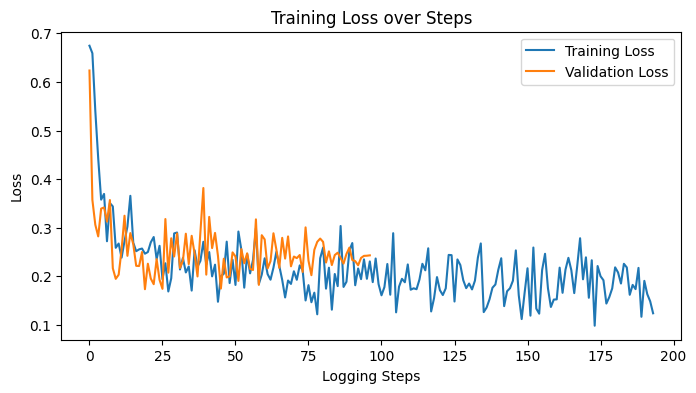

In [49]:
import matplotlib.pyplot as plt

loss_values = [entry["loss"] for entry in trainer.state.log_history if "loss" in entry]
eval_values = [entry["eval_loss"] for entry in trainer.state.log_history if "eval_loss" in entry]

plt.figure(figsize=(8, 4))
plt.plot(loss_values, label="Training Loss")
plt.plot(eval_values, label="Validation Loss")
plt.xlabel("Logging Steps")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.legend()
plt.show()

              precision    recall  f1-score   support

    negative       0.99      0.83      0.90       913
    positive       0.34      0.93      0.50        87

    accuracy                           0.83      1000
   macro avg       0.66      0.88      0.70      1000
weighted avg       0.94      0.83      0.87      1000



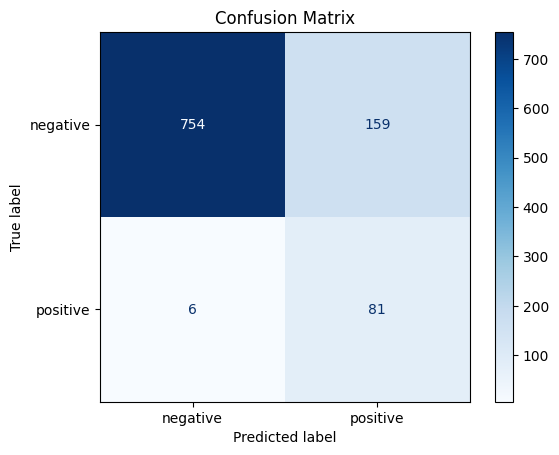

In [50]:
y_true_lora = []
y_pred_lora = []

for batch in test_dataloader:
    input_ids, attention_mask, labels = batch['input_ids'], batch['attention_mask'], batch['labels']
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    with torch.no_grad():
        outputs = lora_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1)
        y_true_lora.extend(labels.cpu().numpy())
        y_pred_lora.extend(batch_predictions.cpu().numpy())

accuracy_lora = accuracy_score(y_true_lora, y_pred_lora)
precision_lora = precision_score(y_true_lora, y_pred_lora, average='weighted')
recall_lora = recall_score(y_true_lora, y_pred_lora, average='weighted')
f1_lora = f1_score(y_true_lora, y_pred_lora, average='weighted')

labels = ["negative", "positive"]

ConfusionMatrixDisplay.from_predictions(
    y_true_lora,
    y_pred_lora,
    display_labels=labels,
    cmap=plt.cm.Blues,
    xticks_rotation='horizontal'
)

plt.title('Confusion Matrix')
plt.show

print(classification_report(y_true_lora, y_pred_lora, target_names=labels))

In [44]:
!zip -r models.zip ./models
# !zip -r models.zip ./logs


  adding: models/ (stored 0%)
  adding: models/bert_even_st/ (stored 0%)
  adding: models/bert_even_st/tokenizer.json (deflated 71%)
  adding: models/bert_even_st/vocab.txt (deflated 53%)
  adding: models/bert_even_st/config.json (deflated 49%)
  adding: models/bert_even_st/model.safetensors (deflated 8%)
  adding: models/bert_even_st/special_tokens_map.json (deflated 42%)
  adding: models/bert_even_st/tokenizer_config.json (deflated 75%)
  adding: models/bert_odd_st/ (stored 0%)
  adding: models/bert_odd_st/tokenizer.json (deflated 71%)
  adding: models/bert_odd_st/vocab.txt (deflated 53%)
  adding: models/bert_odd_st/config.json (deflated 49%)
  adding: models/bert_odd_st/model.safetensors (deflated 8%)
  adding: models/bert_odd_st/special_tokens_map.json (deflated 42%)
  adding: models/bert_odd_st/tokenizer_config.json (deflated 75%)


In [45]:
from IPython.display import FileLink

FileLink(r'models.zip')

/kaggle/working/models.zip

## Evaluation and Analysis

### 1) Model Evaluation and Performance Comparison

#### Training Loss and Test Set Performance

| Model Type | Training Loss | Test Set Accuracy | Precision (Negative) | Recall (Negative) | F1-Score (Negative) | Precision (Positive) | Recall (Positive) | F1-Score (Positive) |
|-----------|---------------|-------------------|-----------------------|--------------------|----------------------|-----------------------|--------------------|----------------------|
| Odd Layer | 0.1682        | 0.9242            | 0.99                  | 0.80               | 0.88                 | 0.31                  | 0.94               | 0.46                 |
| Even Layer| 0.1682        | 0.9236            | 0.99                  | 0.80               | 0.89                 | 0.31                  | 0.91               | 0.46                 |
| LoRA      | 0.1168        | 0.8800            | 0.99                  | 0.83               | 0.90                 | 0.34                  | 0.93               | 0.50                 |

#### Analysis

1. **Odd and Even Layer Models:**
   - Both models exhibit similar training losses, converging to around **0.1682**.
   - Test set performance is also comparable, with **Odd Layer slightly outperforming Even Layer** (0.9242 vs 0.9236).
   - Both models show good accuracy but **slightly underperform in recall and f1-score for the positive class**, likely due to class imbalance or less representation of positive samples.

2. **LoRA Model:**
   - The **training loss for LoRA** is significantly lower (**0.1168**), indicating a more stable and efficient convergence during training.
   - The **test set performance (accuracy)** is **0.88**, which is slightly lower than both Odd and Even Layer models.
   - However, LoRA shows an **improved recall and f1-score for the positive class**, which is crucial for certain applications (like fraud detection or medical diagnostics).

#### Performance Comparison:
- LoRA demonstrates better handling of positive class predictions but compromises on overall accuracy compared to Odd and Even Layer models.
- The slight discrepancy between the Odd and Even Layer models' performance might be due to differences in how the layers capture feature representations, especially in tasks where the **order of layers affects model capacity**.

---

### 2) Challenges and Improvements

#### Challenges Encountered:
1. **Training Stability:**
   - The LoRA model shows fluctuations in validation loss after reaching a lower value, indicating potential **overfitting or instability**.
   - The Odd and Even Layer models, despite having similar training losses, show different behaviors during testing, suggesting **layer-specific challenges in representation learning**.

2. **Generalization and Recall:**
   - LoRA shows better recall for the positive class, while the Odd and Even Layer models struggle with it. This could indicate that **LoRA fine-tuning preserves essential features**, while distillation fine-tuning might **oversimplify feature representations**, leading to **poor recall**.

#### Proposed Improvements:
1. **Hybrid Fine-Tuning:**
   - Combining **LoRA and layer-based distillation** could leverage the strengths of both methods, balancing **recall and accuracy**.

2. **Regularization and Data Augmentation:**
   - Applying techniques like **dropout, data augmentation, or ensemble methods** could improve the generalization of all models.

3. **Layer-Wise Analysis:**
   - Further investigation into the **representational power of Odd vs. Even layers** can help design better distilled models by identifying **which layers contribute most to performance**.
